## Loop to get the Spatial Structure Parameters

In [16]:
using PyCall
using Distributions, Statistics, Distances
using DataFrames
using LightGraphs, SimpleWeightedGraphs
using Random , Printf, Glob

import PyPlot , CSV
import Distances, StatsBase

rootdir = "/home/stephane/Science/cluster/GAIA"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

## directory
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/testdens"
ocdir= "$wdir/oc"

cd(wdir)

In [17]:
cd(ocdir)
files= glob("*csv")
cd(wdir)

df = DataFrame(voname= String[], C= Float64[], Cerr= Float64[], s= Float64[], serr= Float64[], m= Float64[],
merr= Float64[])

fitflag= false
for f in files
    if fitflag
        fname= f[1:end-4] ; fvot= f[1:end-7]
        oc= CSV.read("$ocdir/$fname.csv" , delim= ";")
        ocfile= "$ocdir/$fname.csv" ; voname= "$fvot.vot"
        println("## ocfile: $voname")
        println("## fitting the radial profile....")
    
        ntest= 100 ; niter= 30000
    
        ## estimating the binning
        nstar= length(oc.X)
        println("## Nstar: $nstar")
        nbin= min(trunc(Int, nstar/10),20)
        println("## NBIN: $nbin")
    
        θfit, θfiterr, fitfound= spatialParameter(ocfile, ntest, nbin, niter, false)
    
        println("## Fit:")
        println(θfit)
        println(θfiterr)
        println(" ")
    
        push!(df, [voname,θfit.C , θfiterr.C, θfit.s , θfiterr.s, θfit.m , θfiterr.m])
    end
end

if fitflag 
    CSV.write("test-fitCauchy-1.csv", df, delim=";") 
else
    println("## No fit...")
end

## No fit...


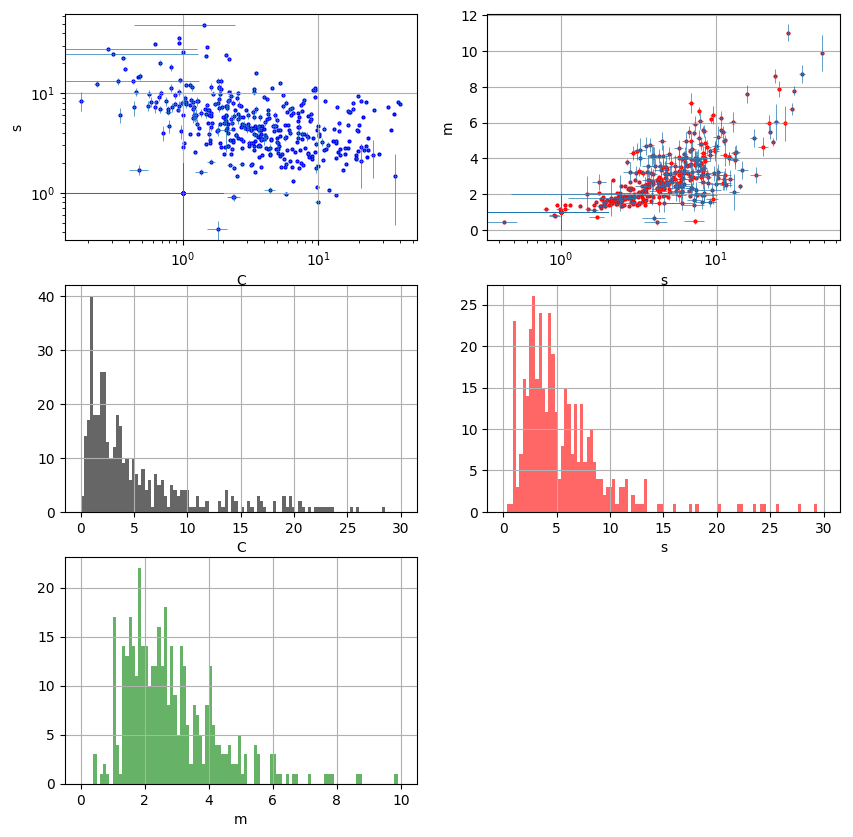

In [18]:
csvfile= "test-fitCauchy.csv"
df= CSV.read(csvfile , delim= ";")


fig= PyPlot.figure(figsize=(10,10))

ax= PyPlot.subplot(321)
PyPlot.grid("on")
ax.set_xscale("log")
ax.set_yscale("log")
PyPlot.xlabel("C")
PyPlot.ylabel("s")
PyPlot.scatter(df.C, df.s , s=4, facecolor="blue" )
PyPlot.errorbar(df.C, df.s, xerr=df.Cerr, yerr=df.serr, linewidth=0.5,ls="none")


ax= PyPlot.subplot(322)
PyPlot.grid("on")
ax.set_xscale("log")
#ax.set_yscale("log")
PyPlot.xlabel("s")
PyPlot.ylabel("m")
PyPlot.scatter(df.s, df.m , s=4, facecolor="red" )
PyPlot.errorbar(df.s, df.m, xerr=df.serr, yerr=df.merr, linewidth=0.5,ls="none")

ax = PyPlot.subplot(323)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(df.C,nbins,range = [0,30], color = "k", alpha=0.6 , label = "C")
PyPlot.xlabel("C")

ax = PyPlot.subplot(324)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(df.s,nbins,range = [0,30], color = "r", alpha=0.6 , label = "s")
PyPlot.xlabel("s")

ax = PyPlot.subplot(325)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(df.m,nbins,range = [0,10], color = "g", alpha=0.6 , label = "s")
PyPlot.xlabel("m")

PyPlot.show()

--------------
## Checking all the fit with data.

Figs saved with data density with Cauchy Fit.

In [19]:
function _plotFitDensityFig(filelist, θlist, ifig, nrow, ncol, ocdir)
    for i in 1:length(filelist)
        # println(θlist[i])
    end
end


function _plotDensity(ocfile, θ, irow, icol, nplot)
    oc= CSV.read(ocfile, delim= ";")
    # binned density
    nbin= 20
    r2d,ρ2d,err2d= density2D(oc.Y, oc.Z, nbin)
    θ= modelCauchy(ot)
    ρ2dfit= model_rad(r2d, θ, fdens1)
    
    
    ax= PyPlot.subplot(111)
    ax.set_xlabel("r [pc]")
    ax.set_ylabel("ρ")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlim(r2d[1]*0.9, r2d[end]*1.1)
    ax.set_ylim(minimum(ρ2d[ρ2d .> 0])*0.3,maximum(ρ2d)*1.5)
    PyPlot.grid("on")
    PyPlot.scatter(r2d, ρ2d , s=4, facecolor="blue" )
    PyPlot.errorbar(r2d, ρ2d, yerr=2 .* err2d, linewidth=0.5)
    PyPlot.plot(r2d, ρ2dfit, "k-", linewidth=1)
end

_plotDensity (generic function with 1 method)

In [20]:
cd(plotdir)

rowperfig= 4
colperfig= 3
plotperfig= rowperfig*colperfig

ifig= 1
plotaccum=0
filevot= [] ; θlist= [] ; θerrlist= []
for item in 1:length(df.voname)
    push!(filevot, df.voname[item])
    θ= GaiaClustering.modelCauchy(df.C[item], df.s[item], df.m[item])
    push!(θlist, θ)
    θerr= GaiaClustering.modelCauchy(df.Cerr[item], df.serr[item], df.merr[item])
    push!(θerrlist, θerr)
    plotaccum += 1
    
    if plotaccum == plotperfig
        # println(filevot)
        println(θlist)
        _plotFitDensityFig(filevot, θlist, ifig,rowperfig, colperfig , ocdir)
        filevot= [] ; θlist= [] ; θerrlist= []
        plotaccum= 0 ; ifig += 1
    end
end

cd(wdir)

Any[GaiaClustering.modelCauchy(3.806130776364534, 3.919125866356956, 2.683992491872644), GaiaClustering.modelCauchy(0.8209195130847133, 11.247971556735342, 2.8730245140029873), GaiaClustering.modelCauchy(3.4660869356693693, 3.763535282301993, 4.764709718756324), GaiaClustering.modelCauchy(4.451523394448105, 2.424941359831677, 1.7847298054339609), GaiaClustering.modelCauchy(0.9218689951088263, 6.765880066163456, 1.8832408550821045), GaiaClustering.modelCauchy(5.911410362893191, 2.6951128708764647, 1.7611831519469092), GaiaClustering.modelCauchy(2.0825052035503324, 6.0172870738448765, 2.1035296261223735), GaiaClustering.modelCauchy(4.941280625496186, 3.5444865139630752, 2.266730105552768), GaiaClustering.modelCauchy(1.8101850437465283, 0.42713909454620336, 0.42874285219574604), GaiaClustering.modelCauchy(1.853181371580786, 11.523419844490556, 3.091312870468891), GaiaClustering.modelCauchy(1.019205328481516, 3.1898485710288194, 1.5317131352199496), GaiaClustering.modelCauchy(3.32594430742

Any[GaiaClustering.modelCauchy(2.577784337980563, 6.191447835051512, 3.181658316896352), GaiaClustering.modelCauchy(0.17784822691002117, 8.41357905638577, 1.938488461675864), GaiaClustering.modelCauchy(4.748013780477998, 4.714682791462744, 2.559634681909427), GaiaClustering.modelCauchy(2.25307635134647, 3.4039517839295668, 3.1788608831316867), GaiaClustering.modelCauchy(1.8090810206446153, 13.315641673996836, 4.280868795883311), GaiaClustering.modelCauchy(1.437568846137989, 48.644677430624995, 9.882100430640666), GaiaClustering.modelCauchy(2.214692091273036, 10.388771017912347, 2.921016644341424), GaiaClustering.modelCauchy(5.656487151871984, 3.578721214828248, 3.221745804506782), GaiaClustering.modelCauchy(2.084281678262562, 5.248842781510119, 2.672882352909637), GaiaClustering.modelCauchy(15.93307804729021, 1.9419532838629292, 1.6234870725802917), GaiaClustering.modelCauchy(2.8623155649942413, 4.424887283067031, 2.271142220791812), GaiaClustering.modelCauchy(23.007531389774407, 2.304

GaiaClustering.modelCauchy(8.423575048380608, 2.477084895737305, 1.6974321340395975)
GaiaClustering.modelCauchy(3.6861336605756425, 4.304729015373454, 4.142672845178597)
GaiaClustering.modelCauchy(4.607347187017007, 4.70553401976045, 3.5375136254840482)
GaiaClustering.modelCauchy(1.2763718375376505, 4.948301098225599, 2.0749188598144648)
GaiaClustering.modelCauchy(5.3932422685618056, 2.4533859677279604, 1.562067931024374)
GaiaClustering.modelCauchy(1.0, 1.0, 1.0)
GaiaClustering.modelCauchy(2.024959914927166, 2.4747129049425642, 1.3328569169753899)
GaiaClustering.modelCauchy(1.0082124418716856, 2.907778154973879, 1.4919470640605117)
GaiaClustering.modelCauchy(3.0710325764061315, 3.1730945052944346, 3.2739966725959295)
GaiaClustering.modelCauchy(3.0265169343187224, 5.998227015737855, 3.542169071432672)
Any[GaiaClustering.modelCauchy(3.3779127276005596, 2.6961649373492578, 1.833109401654385), GaiaClustering.modelCauchy(1.3755007172955482, 1.62184441456578, 1.0979416370123343), GaiaCluster

GaiaClustering.modelCauchy(3.308837431958127, 3.1486835185893436, 1.8556258193297466)
GaiaClustering.modelCauchy(1.615093394167172, 4.576110206479948, 2.482626795205265)
GaiaClustering.modelCauchy(19.160824234441428, 2.4007799916095958, 1.9919600110625062)
GaiaClustering.modelCauchy(13.455723984768486, 0.9390328414197044, 1.3738527707016088)
GaiaClustering.modelCauchy(11.977835164172934, 1.0549556881412678, 1.4054588516847482)
GaiaClustering.modelCauchy(9.444485380387299, 10.741126175301154, 6.241240670364804)
GaiaClustering.modelCauchy(4.777392468931361, 5.999122868906713, 3.1889074633742687)
GaiaClustering.modelCauchy(1.1412466485266473, 12.204127833427782, 4.013102442189853)
GaiaClustering.modelCauchy(8.45482869486495, 3.6317882724578885, 2.819084824451404)
Any[GaiaClustering.modelCauchy(19.770144305026324, 2.596656980627566, 2.4587809300120806), GaiaClustering.modelCauchy(5.869074866635034, 6.4721802186753985, 3.5699675044343255), GaiaClustering.modelCauchy(2.768098768611023, 5.813

GaiaClustering.modelCauchy(1.9002085343866943, 3.123670512317079, 2.042810741699703)
GaiaClustering.modelCauchy(1.3013818145116722, 8.432538425013409, 3.4781208553520155)
GaiaClustering.modelCauchy(7.582445315958978, 6.63747461276147, 3.1672223423194894)
GaiaClustering.modelCauchy(8.49102382630758, 5.964087279322979, 3.0861941986745896)
GaiaClustering.modelCauchy(19.95543385506362, 4.822145230221344, 3.398434063556592)
GaiaClustering.modelCauchy(21.4576958235019, 5.81293002719787, 4.021348531417196)
GaiaClustering.modelCauchy(13.519331451016932, 3.3223620696767324, 2.2038986972107217)
GaiaClustering.modelCauchy(6.474341068747035, 1.3247533712108353, 1.3175563754805308)
GaiaClustering.modelCauchy(1.1311976775981032, 3.9024115201993705, 1.861370990286961)
Any[GaiaClustering.modelCauchy(16.98154014908592, 6.441529825649748, 3.6583530104103597), GaiaClustering.modelCauchy(1.2084752469823576, 7.338947332038941, 4.025112283363816), GaiaClustering.modelCauchy(2.3873436559107493, 1.77952559320

GaiaClustering.modelCauchy(2.728677045742147, 1.9376988870713507, 1.5059817615436906)
GaiaClustering.modelCauchy(5.723325089529076, 1.8157530485164517, 1.3445357486434013)
GaiaClustering.modelCauchy(2.192230853680905, 8.483903442992606, 3.8419015410814086)
GaiaClustering.modelCauchy(5.832986621358632, 1.92017738641615, 1.3613818546732375)
GaiaClustering.modelCauchy(2.1365336251447404, 7.401560550206107, 3.8752264987883174)
GaiaClustering.modelCauchy(4.180812710798804, 5.466924491533684, 3.207930940967023)
Any[GaiaClustering.modelCauchy(3.9711652282958037, 4.318134100263453, 2.5824937233472247), GaiaClustering.modelCauchy(4.372277054751652, 5.6303015890429515, 2.6419921136937323), GaiaClustering.modelCauchy(7.838530487817734, 8.49352171556552, 4.853747831420483), GaiaClustering.modelCauchy(5.199575971111186, 3.676889362076949, 1.8834794052189041), GaiaClustering.modelCauchy(5.026290566259284, 4.315083517953406, 2.188495356752745), GaiaClustering.modelCauchy(7.064363005037106, 5.20126796

GaiaClustering.modelCauchy(1.6151300006145903, 6.264242675762439, 3.2300134394694804)
Any[GaiaClustering.modelCauchy(2.316150127745823, 2.7609883269615727, 1.32412979938618), GaiaClustering.modelCauchy(1.1745229547655782, 11.5200489720223, 4.180545674240148), GaiaClustering.modelCauchy(1.0409819344684033, 8.943892465219214, 2.6071636101300255), GaiaClustering.modelCauchy(0.9433065730405298, 10.216142726262056, 3.0664374488783737), GaiaClustering.modelCauchy(2.522799534834736, 1.4882109212362709, 1.1795268431117196), GaiaClustering.modelCauchy(2.3732625315613407, 3.3572546111444335, 1.848463312504774), GaiaClustering.modelCauchy(4.046146205183523, 3.5389720947799104, 1.6505873759574474), GaiaClustering.modelCauchy(7.754228541713581, 7.9703080249642, 4.803977570982012), GaiaClustering.modelCauchy(3.975046327220058, 9.195696343544562, 4.19662223260155), GaiaClustering.modelCauchy(1.9069143362102718, 11.087830619568143, 2.640830332718906), GaiaClustering.modelCauchy(5.512509865884845, 7.37